# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import cv2
import random
import tensorflow as tf
import seaborn as sns
import os
import random
import keras

from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Activation, InputLayer, BatchNormalization  
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
                    
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib.image import imread
from sklearn.cluster import KMeans

keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


# Import Datasets

In [2]:
L_images = np.load('l/gray_scale.npy')

In [3]:
AB_images_1 = np.load('ab/ab/ab1.npy')
AB_images_2 = np.load('ab/ab/ab2.npy')
AB_images_3 = np.load('ab/ab/ab3.npy')

# Exploratory Data Analysis

In [4]:
L_images.shape

(25000, 224, 224)

In [5]:
AB_images_1.shape

(10000, 224, 224, 2)

In [6]:
AB_images = np.concatenate((AB_images_1, AB_images_2, AB_images_3))

AB_images.shape

# Preprocessing L_images to make RGB

In [7]:
def prep_L(L_images, batch_size = 300):
    # Create and empty array of given batch size, 224x224, with three channels
    # so that the L channel can fall in a tensor that will eventually hold all three
    # RGB channels
    L_imgs = np.zeros((batch_size, 224, 224, 3))
    # fFr every channel in range 2
    for i in range(0, 3):
        # a new image in the RGB_imgs array will be a greyscale image from L_images
        L_imgs[:batch_size, :, :,i] = L_images[:batch_size]
    # Return the standardized version of this new array.
    return preprocess_input(L_imgs)

# Creating RGB targets from L and AB values

In [8]:
def make_RGB(L_images, AB_images, batch_size = 300):
    # Create and empty array of the appropriate size to hold
    # L and AB images. It will be of batch size, 224x244
    # and be composed of three color channels for RGB
    RGB_imgs = np.zeros((batch_size, 224, 224, 3))
    # The first color channel will be the L in L_images, up to the batch size
    RGB_imgs[:, :, :, 0] = L_images[0:batch_size]
    # The second /third color channels will be the AB from AB_images
    RGB_imgs[:, :, :, 1:] = AB_images[0:batch_size]
    # Convert everything to the same file type
    RGB_imgs = RGB_imgs.astype("uint8")
    # Create a new empty list to hold all of the RGB images
    RGB_array = []
    # for every image in the range of the batch size, convert LAB to RGB
    # and then append to our empty list of imgs_
    for i in range(0, batch_size):
        RGB_array.append(cv2.cvtColor(RGB_imgs[i], cv2.COLOR_LAB2RGB))
    # Turn our new list of RGB images back into an array   
    RGB_array = np.array(RGB_array)
    return RGB_array

# Creating Train and Target Data

In [9]:
imgs_input = prep_L(L_images, batch_size = 300)

In [10]:
imgs_output = preprocess_input(make_RGB(L_images, AB_images, batch_size = 300))

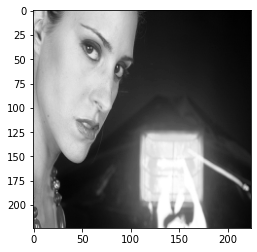

In [11]:
plt.imshow(L_images[25], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


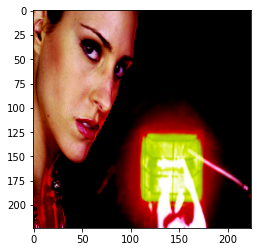

In [12]:
plt.imshow(imgs_output[25]);

# Building a Baseline Deep Convolutional GAN

In [16]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(224*224*3, input_shape=[codings_size]),
    keras.layers.Reshape([224,224,3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same',
                                activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same',
                                activation='tanh')
])

In [17]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                       activation=keras.layers.LeakyReLU(0.2),
                       input_shape=[224,224,3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same',
                       activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='tanh',)
])

/home/alexhmacy/anaconda3/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [18]:
gan = keras.models.Sequential([generator, discriminator])

In [19]:
discriminator.compile(loss='mse', optimizer='adam')
discriminator.trainable = False
gan.compile(loss='mse', optimizer='adam')

In [21]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(imgs_input).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [25]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise, y2)

In [26]:
train_gan(gan, dataset, batch_size, codings_size)

ValueError: Tensor conversion requested dtype float64 for Tensor with dtype float32: <tf.Tensor 'sequential_1_2/conv2d_transpose_3/Tanh:0' shape=(32, 28, 28, 1) dtype=float32>

In [16]:
# Building the neural network
updated_model = Sequential()
updated_model.add(InputLayer(input_shape=(224,224,3)))
updated_model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=1))
updated_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=1))
updated_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=1))
updated_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [17]:
# Finish model
updated_model.compile(optimizer='adam',loss='mse', metrics=['acc'])

In [18]:
updated_model.fit(imgs_input, imgs_output, epochs = 100)

Epoch 1/100
300/300 [==============================] - 40s 134ms/step - loss: 0.8957 - acc: 0.5996
Epoch 2/100
300/300 [==============================] - 37s 123ms/step - loss: 0.4877 - acc: 0.4880
Epoch 3/100
300/300 [==============================] - 38s 125ms/step - loss: 0.3725 - acc: 0.1880
Epoch 4/100
300/300 [==============================] - 38s 126ms/step - loss: 0.3565 - acc: 0.5184
Epoch 5/100
300/300 [==============================] - 38s 126ms/step - loss: 0.3548 - acc: 0.5981
Epoch 6/100
300/300 [==============================] - 38s 128ms/step - loss: 0.3472 - acc: 0.5831
Epoch 7/100
300/300 [==============================] - 38s 125ms/step - loss: 0.3416 - acc: 0.5436
Epoch 8/100
300/300 [==============================] - 38s 126ms/step - loss: 0.3390 - acc: 0.5052
Epoch 9/100
300/300 [==============================] - 38s 126ms/step - loss: 0.3345 - acc: 0.5393
Epoch 10/100
300/300 [==============================] - 38s 126ms/step - loss: 0.3333 - acc: 0.5703
Epoch 11/

300/300 [==============================] - 39s 131ms/step - loss: 0.3268 - acc: 0.5833
Epoch 84/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3266 - acc: 0.5886
Epoch 85/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3268 - acc: 0.5790
Epoch 86/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3267 - acc: 0.5873
Epoch 87/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3268 - acc: 0.5884
Epoch 88/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3266 - acc: 0.5838
Epoch 89/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3265 - acc: 0.5866
Epoch 90/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3265 - acc: 0.5806
Epoch 91/100
300/300 [==============================] - 39s 132ms/step - loss: 0.3265 - acc: 0.5892
Epoch 92/100
300/300 [==============================] - 39s 131ms/step - loss: 0.3266 - acc: 0.5838
Epoch 93/100


In [19]:
output = updated_model.predict(imgs_input)

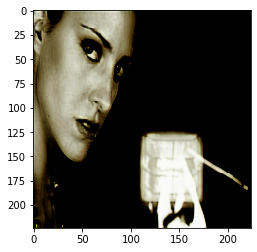

In [20]:
plt.imshow(output[25])

In [24]:
acc_stopping_cb = keras.callbacks.EarlyStopping(patience=75, monitor='acc',
                                                restore_best_weights=True)

In [26]:
updated_model.fit(imgs_input, imgs_output, epochs = 200, callbacks=[acc_stopping_cb])

Epoch 1/200
300/300 [==============================] - 68s 226ms/step - loss: 0.3263 - acc: 0.5861
Epoch 2/200
300/300 [==============================] - 68s 225ms/step - loss: 0.3262 - acc: 0.5853
Epoch 3/200
300/300 [==============================] - 67s 224ms/step - loss: 0.3263 - acc: 0.5866
Epoch 4/200
300/300 [==============================] - 67s 224ms/step - loss: 0.3262 - acc: 0.5817
Epoch 5/200
300/300 [==============================] - 68s 226ms/step - loss: 0.3262 - acc: 0.5771
Epoch 6/200
300/300 [==============================] - 68s 227ms/step - loss: 0.3262 - acc: 0.5860
Epoch 7/200
300/300 [==============================] - 69s 228ms/step - loss: 0.3263 - acc: 0.5842
Epoch 8/200
300/300 [==============================] - 68s 228ms/step - loss: 0.3263 - acc: 0.5922
Epoch 9/200
300/300 [==============================] - 68s 227ms/step - loss: 0.3263 - acc: 0.5876
Epoch 10/200
300/300 [==============================] - 68s 228ms/step - loss: 0.3265 - acc: 0.5773
Epoch 11/

300/300 [==============================] - 67s 222ms/step - loss: 0.3258 - acc: 0.5859
Epoch 84/200
300/300 [==============================] - 66s 220ms/step - loss: 0.3258 - acc: 0.5866
Epoch 85/200
300/300 [==============================] - 69s 231ms/step - loss: 0.3258 - acc: 0.5911
Epoch 86/200
300/300 [==============================] - 69s 230ms/step - loss: 0.3262 - acc: 0.5848
Epoch 87/200
300/300 [==============================] - 68s 228ms/step - loss: 0.3262 - acc: 0.5808
Epoch 88/200
300/300 [==============================] - 68s 227ms/step - loss: 0.3260 - acc: 0.5866
Epoch 89/200
300/300 [==============================] - 69s 231ms/step - loss: 0.3260 - acc: 0.6002
Epoch 90/200
300/300 [==============================] - 73s 245ms/step - loss: 0.3260 - acc: 0.5897
Epoch 91/200
300/300 [==============================] - 51s 169ms/step - loss: 0.3260 - acc: 0.5819
Epoch 92/200
300/300 [==============================] - 39s 131ms/step - loss: 0.3258 - acc: 0.5880
Epoch 93/200


In [27]:
output = updated_model.predict(imgs_input)

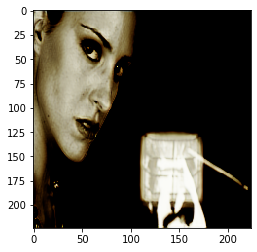

In [28]:
plt.imshow(output[25])

# Another approach... Testing

In [29]:
# Building the neural network
new_model = Sequential()
new_model.add(InputLayer(input_shape=(224,224,3)))
new_model.add(Conv2D(8, (3, 3), activation='tanh', padding='same', strides=1))
new_model.add(Conv2D(8, (3, 3), activation='tanh', padding='same'))
new_model.add(Conv2D(16, (3, 3), activation='tanh', padding='same'))
new_model.add(Conv2D(16, (3, 3), activation='tanh', padding='same', strides=1))
new_model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
new_model.add(Conv2D(32, (3, 3), activation='tanh', padding='same', strides=1))
new_model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
new_model.add(Conv2D(16, (3, 3), activation='tanh', padding='same'))
new_model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [30]:
# Finish model
new_model.compile(optimizer='adam',loss='mse', metrics=['acc'])

In [31]:
new_model.fit(imgs_input, imgs_output, epochs = 100)

Epoch 1/100
300/300 [==============================] - 38s 128ms/step - loss: 0.6110 - acc: 0.2058
Epoch 2/100
300/300 [==============================] - 40s 134ms/step - loss: 0.4608 - acc: 0.2077
Epoch 3/100
300/300 [==============================] - 40s 132ms/step - loss: 0.3966 - acc: 0.2396
Epoch 4/100
300/300 [==============================] - 40s 133ms/step - loss: 0.3684 - acc: 0.2365
Epoch 5/100
300/300 [==============================] - 40s 132ms/step - loss: 0.3527 - acc: 0.2842
Epoch 6/100
300/300 [==============================] - 40s 133ms/step - loss: 0.3485 - acc: 0.4356
Epoch 7/100
300/300 [==============================] - 40s 132ms/step - loss: 0.3433 - acc: 0.5220
Epoch 8/100
300/300 [==============================] - 40s 132ms/step - loss: 0.3390 - acc: 0.4993
Epoch 9/100
300/300 [==============================] - 40s 133ms/step - loss: 0.3368 - acc: 0.4511
Epoch 10/100
300/300 [==============================] - 40s 134ms/step - loss: 0.3352 - acc: 0.5108
Epoch 11/

300/300 [==============================] - 39s 130ms/step - loss: 0.3271 - acc: 0.5790
Epoch 84/100
300/300 [==============================] - 39s 129ms/step - loss: 0.3276 - acc: 0.5817
Epoch 85/100
300/300 [==============================] - 39s 129ms/step - loss: 0.3270 - acc: 0.5967
Epoch 86/100
300/300 [==============================] - 39s 129ms/step - loss: 0.3274 - acc: 0.5829
Epoch 87/100
300/300 [==============================] - 42s 139ms/step - loss: 0.3273 - acc: 0.5963
Epoch 88/100
300/300 [==============================] - 40s 134ms/step - loss: 0.3266 - acc: 0.5810
Epoch 89/100
300/300 [==============================] - 39s 130ms/step - loss: 0.3266 - acc: 0.5732
Epoch 90/100
300/300 [==============================] - 39s 130ms/step - loss: 0.3268 - acc: 0.5862
Epoch 91/100
300/300 [==============================] - 39s 129ms/step - loss: 0.3266 - acc: 0.5858
Epoch 92/100
300/300 [==============================] - 39s 130ms/step - loss: 0.3266 - acc: 0.5940
Epoch 93/100


In [32]:
new_output = new_model.predict(imgs_input)

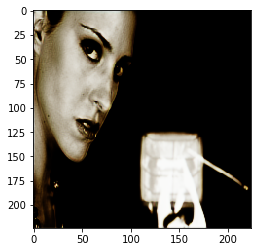

In [33]:
plt.imshow(new_output[25])

# CNN, refined

In [17]:
# Building the neural network
normal_model = Sequential()
normal_model.add(InputLayer(input_shape=(224,224,3)))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
normal_model.add(BatchNormalization())
normal_model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

In [18]:
# Finish model
normal_model.compile(optimizer='adam',loss='mse', metrics=['acc'])

In [22]:
new_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor='acc',
                                                restore_best_weights=True)

In [23]:
normal_model.fit(imgs_input, imgs_output, epochs = 25, callbacks=[new_stopping_cb])

Epoch 1/25
300/300 [==============================] - 345s 1s/step - loss: 0.1426 - acc: 0.3414
Epoch 2/25
300/300 [==============================] - 347s 1s/step - loss: 0.0860 - acc: 0.3844
Epoch 3/25
300/300 [==============================] - 346s 1s/step - loss: 0.0735 - acc: 0.4320
Epoch 4/25
300/300 [==============================] - 347s 1s/step - loss: 0.0702 - acc: 0.4275
Epoch 5/25
300/300 [==============================] - 346s 1s/step - loss: 0.0681 - acc: 0.4492
Epoch 6/25
300/300 [==============================] - 347s 1s/step - loss: 0.0620 - acc: 0.4494
Epoch 7/25
300/300 [==============================] - 347s 1s/step - loss: 0.0735 - acc: 0.4688
Epoch 8/25
300/300 [==============================] - 347s 1s/step - loss: 0.0727 - acc: 0.4598
Epoch 9/25
300/300 [==============================] - 347s 1s/step - loss: 0.0694 - acc: 0.4786
Epoch 10/25
300/300 [==============================] - 347s 1s/step - loss: 0.0690 - acc: 0.4540
Epoch 11/25
300/300 [==================

In [24]:
normal_output = normal_model.predict(imgs_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


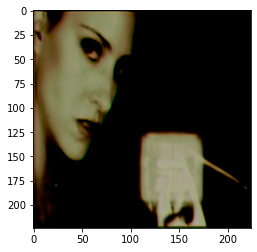

In [25]:
plt.imshow(normal_output[25])

# Utilizing Dropout

In [27]:
# Building the neural network
dropout_model = Sequential()
dropout_model.add(InputLayer(input_shape=(224,224,3)))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dropout_model.add(Dropout(0.4))
dropout_model.add(BatchNormalization())
dropout_model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

In [28]:
# Finish model
dropout_model.compile(optimizer='adam',loss='mse', metrics=['acc'])

In [29]:
new_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor='acc',
                                                restore_best_weights=True)

In [31]:
dropout_model.fit(imgs_input, imgs_output, epochs = 10, callbacks=[new_stopping_cb])

Epoch 1/10
300/300 [==============================] - 383s 1s/step - loss: 0.3107 - acc: 0.3816
Epoch 2/10
300/300 [==============================] - 477s 2s/step - loss: 0.1126 - acc: 0.3502
Epoch 3/10
300/300 [==============================] - 551s 2s/step - loss: 0.0971 - acc: 0.4145
Epoch 4/10
300/300 [==============================] - 482s 2s/step - loss: 0.0934 - acc: 0.4314
Epoch 5/10
300/300 [==============================] - 382s 1s/step - loss: 0.0867 - acc: 0.4109
Epoch 6/10
300/300 [==============================] - 382s 1s/step - loss: 0.0893 - acc: 0.4353
Epoch 7/10
300/300 [==============================] - 382s 1s/step - loss: 0.0874 - acc: 0.4275
Epoch 8/10
300/300 [==============================] - 382s 1s/step - loss: 0.0807 - acc: 0.4314
Epoch 9/10
300/300 [==============================] - 382s 1s/step - loss: 0.0852 - acc: 0.4377
Epoch 10/10
300/300 [==============================] - 427s 1s/step - loss: 0.0786 - acc: 0.4343


In [32]:
dropout_output = dropout_model.predict(imgs_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


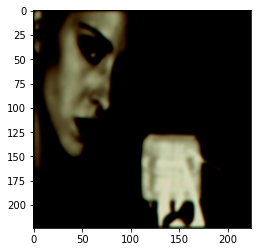

In [33]:
plt.imshow(dropout_output[25])